This notebook shows a tutorial of generating a large image of 15 arcmin using _montage_wrapper_ and how to retrieve a catalog of sources within the same region of the sky from the AllWISE catalog.

In [1]:
import sys
sys.path.append('/users/cmofokeng/rgz_rcnn/tools/')
import os
import os.path as osp
import montage_wrapper as montage
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif', weight='bold',size=60)
plt.rc('axes',labelweight='bold',labelsize='large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

from astropy.stats import SigmaClip,sigma_clipped_stats
from astropy.io.votable import parse
import astropy.io.fits as pyfits
import astropy.wcs as pywcs


import functions
%matplotlib inline

In [2]:
catalog_file = "/idia/users/cmofokeng/data/gmrt/en1w610-5sg9-clean-offset.vot"
    
catalog = parse(catalog_file)
table = catalog.get_first_table()

name = table.array['Source_id']
r = table.array['RA_deg']
d = table.array['Dec_deg']

In [3]:
fits_file = 'gmrt_en1w610_clipped.fits'

f = pyfits.open(fits_file)
fhead = f[0].header
f.close()

In [4]:
i = 1000
ra = r[i]
dec = d[i]
        
npix = 15.0/abs(fhead['CDELT1']*60) # each cutout must be of size 15.0 arcmin.
                                   # so diving that by pixel scale [degrees per pixel] of the fits file to get number of pixels.
    
#width = abs(180 * ) #width of the output square cutout
width = abs(int(npix)*fhead['CDELT1'])
#print(width)
        
fid = osp.basename(fits_file).replace('.fits', '_15arcmin_%s.fits'%(name[i]))
cutout_fname = osp.join("./15arcmin", fid) #file name for the output file
        
montage.mSubimage(fits_file,cutout_fname,ra,dec,width) # generate the cutouts of given size from the given central position

stat : OK
content : normal

In [5]:
import subprocess

data_dir = "/users/cmofokeng/rgz_rcnn/output_gmrt/15arcmin/"

file = pyfits.open(cutout_fname)
data = file[0].data
#file.close()
h = data.shape[-2] #y
w = data.shape[-1] #x
        
# central positions in pixel coordinates
cx = int(w / 2)
cy = int(h / 2)
#print(cx, cy)
fhead = file[0].header
file.close()
#warnings.simplefilter("ignore")
wcsradio = pywcs.WCS(fhead, naxis=2)

radius = max(fhead['CDELT1'] * cx, fhead['CDELT2'] * cy) # in arcsec (CDELT1[arcsec/pixels] * cy[pixels])

# query string used to qeury the database
qstring = "https://irsa.ipac.caltech.edu/SIA?COLLECTION=wise_allwise&POS=circle+%.4f+%.4f+%.6f&RESPONSEFORMAT=CSV"%(ra, dec, radius)
f_out = "%s.csv"%(osp.join("./15arcmin", osp.splitext(osp.basename(cutout_fname))[0]))

# download the csv file of source positions within this region
cmd = 'wget -O %s %s'%(f_out,qstring)
subprocess.call(cmd.split())

0

In [6]:
# download AllWISE (W1) FITS images of the same regions
from collections import defaultdict
import csv

csv_fname = cutout_fname.replace(".fits",".csv")

mapping = defaultdict(list)
with open(csv_fname, 'rt') as votable:
    reader = csv.DictReader(votable)
    match = 0
    for row in reader:
        csv_base = osp.basename(csv_fname)
        if ('W1' == row['energy_bandpassname'] and 'image/fits' == row['access_format']):
            url = row['access_url']
            wise_suffix = '_%d_wise.fits' % match
            mapping[csv_base.replace('.csv', '.fits')].append(csv_base.replace('.csv', wise_suffix))
                    
            out_file = osp.join(".","%s"%csv_fname.replace('.csv', wise_suffix))
            if osp.exists(out_file):
                continue
            #cmd = ["wget","-O",out_file,url]
            cmd = 'wget -O %s %s'%(out_file,url)
            subprocess.call(cmd.split())
            #run_command(cmd.split())
                    
            #print('wget -O %s %s' % (fn.replace('.csv', wise_suffix), url))
            match += 1
                    
with open(osp.join("./15arcmin", 'mapping_neighbour_'+str(name[i])+'.txt'), 'wt') as fout:
    for k, v in list(mapping.items()):
        l = "%s,%s" % (k, ','.join(v))
        fout.write(l)
        fout.write(os.linesep)

In [7]:
# create a link between two files
def force_symlink(file1, file2):
    try:
        os.symlink(file1, file2)
    except OSError as e:
        if e.errno == errno.EEXIST:
            os.remove(file2)
            os.symlink(file1, file2)

In [8]:
# coadd tiles that overlap
wise_dict = dict()
with open(osp.join("./15arcmin", 'mapping_neighbour_'+str(name[i])+'.txt'), 'r') as fin:
    mylist = fin.read().splitlines()
    for line in mylist:
        ll = line.split(',')
        wise_dict[ll[0]] = ll[1:]
            
with open(osp.join(".","MontageError_coadd.txt"), "wt") as f:
    fname = osp.join("./15arcmin","gmrt_en1w610_clipped_15arcmin"+str(name[i])+".fits")
    fn = osp.basename(fname)
#     for fn in os.listdir(split_fits_dir):
    if (fn in wise_dict):
        #print(fn)
        #continue
        #fname = osp.join(split_fits_dir, fn)
        if (fname.endswith('.fits') and fn.find('wise') == -1):
            dirn = fname.replace('.fits', '_dir')
            if (not osp.exists(dirn)):
                os.mkdir(dirn)
                #run_command(["mkdir",dirn])
            ir_list = wise_dict[fn]
            for ir_fn in ir_list:
                # co-add works on projected images
                ir_fn = ir_fn.replace('_wise.fits', '_wise_regrid.fits')
                dst = osp.join(".", dirn, ir_fn)
                #if (osp.exists(dst)):
                    #print("skip creating %s" % dst)
                    #continue
                src = osp.join(".", ir_fn)
                force_symlink(src,dst)
                    #os.symlink(src, dst)
            tbl_fn = fname.replace('.fits', '.tbl')
            if (not osp.exists(tbl_fn)):
                #cmd = '%s %s %s' % (imgtbl_exec, dirn, tbl_fn)
                print(len(os.listdir(dirn)))
                try:
                    montage.mImgtbl(dirn, tbl_fn)
                        
                except montage.status.MontageError:
                    montage.mAdd(tbl_fn,hdr_tpl,outfile)

            # coadd requires the area file co-located in the same directory as input fits
            for ir_fn in ir_list:
                ir_fn = ir_fn.replace('_wise.fits', '_wise_regrid_area.fits')
                dst = osp.join(".", dirn, ir_fn)
                #if (osp.exists(dst)):
                    #print("skip creating %s" % dst)
                    #continue
                src = osp.join(".", ir_fn)
                force_symlink(src,dst)

            outfile = fname.replace('.fits', '_wise_coadd.fits')
            if (not osp.exists(outfile) and len(os.listdir(dirn))>2): 
                hdr_tpl = fname.replace('.fits', '_gmrt.hdr')   
                #cmd = '%s %s %s %s' % (coadd_exec, tbl_fn, hdr_tpl, outfile)
                try:
                    montage.mAdd(tbl_fn,hdr_tpl,outfile)
                    print("Coadding to ",outfile)
 
                except montage.status.MontageError:
                    montage.mAdd(tbl_fn,hdr_tpl,outfile)

In [ ]:
tbl = "/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_"+str(name[i])+".tbl"
montage.mImgtbl('/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/gmrt_en1w610_clipped_'+str(name[i])+_dir/', tbl)

If the above code did not create any directory, this is due to the fact that there are no overlapping tiles for the respective region, there is only one AllWISE cuotut covering the same region. Thus, the below code will work for a single cutout.

__PS:__ The code below is only run given the code above did not create any directory.

In [9]:
wise_dict = dict()
with open(osp.join("./15arcmin", 'mapping_neighbour_'+str(name[i])+'.txt'), 'r') as fin:
    mylist = fin.read().splitlines()
    for line in mylist:
        ll = line.split(',')
        wise_dict[ll[0]] = ll[1:]
        
fname = "/users/cmofokeng/rgz_rcnn/output_gmrt/15arcmin/gmrt_en1w610_clipped_15arcmin_"+str(name[i])+".fits"
fn = osp.basename(fname)


hdr_tpl = osp.join("./15arcmin", fn.replace('.fits', '_gmrt.hdr'))
if (not osp.exists(hdr_tpl)):
    file = pyfits.open(fname)
    head = file[0].header.copy()
    head.totextfile(hdr_tpl, overwrite=True)
    
    
ir_list = wise_dict[fn]
for ir_fn in ir_list:
    outfile = osp.join("./15arcmin",ir_fn.replace('_wise', '_wise_regrid')) # wise_regrid
            
    if (not osp.exists(outfile)):
        #print("Projecting image to %s"%outfile)
        rtn = montage.mProject(osp.join("./15arcmin",ir_fn),outfile,hdr_tpl)
        print(rtn)

In [12]:
wise_file = cutout_fname.replace(".fits","_0_wise_regrid.fits") # change "_0_wise_regrid.fits" to "_wise_coadd.fits"
                                                                # only if overlapping tiles were found and directory was created for them
output_fname = wise_file.replace("regrid.fits","filled.fits")

with pyfits.open(wise_file) as file:
    hduwise = file[0]
    wcswise = pywcs.WCS(hduwise.header, naxis=2)
    #fits_data = hduradio.data
    mean, _, _ = sigma_clipped_stats(hduwise.data, sigma=3.0, maxiters=5)

    hduwise.data[np.isnan(hduwise.data)] = mean

    hduwise.header.remove('CRPIX3')
    hduwise.header.remove('CRVAL3')
    hduwise.header.remove('CDELT3')
    #hduwise.header.remove('CUNIT3')
    hduwise.header.remove('CTYPE3')
    hduwise.header.remove('NAXIS3')
    hduwise.header.remove('NAXIS4')

    hduwise.writeto(output_fname)

OSError: File './15arcmin/gmrt_en1w610_clipped_15arcmin_1020_0_wise_filled.fits' already exists.

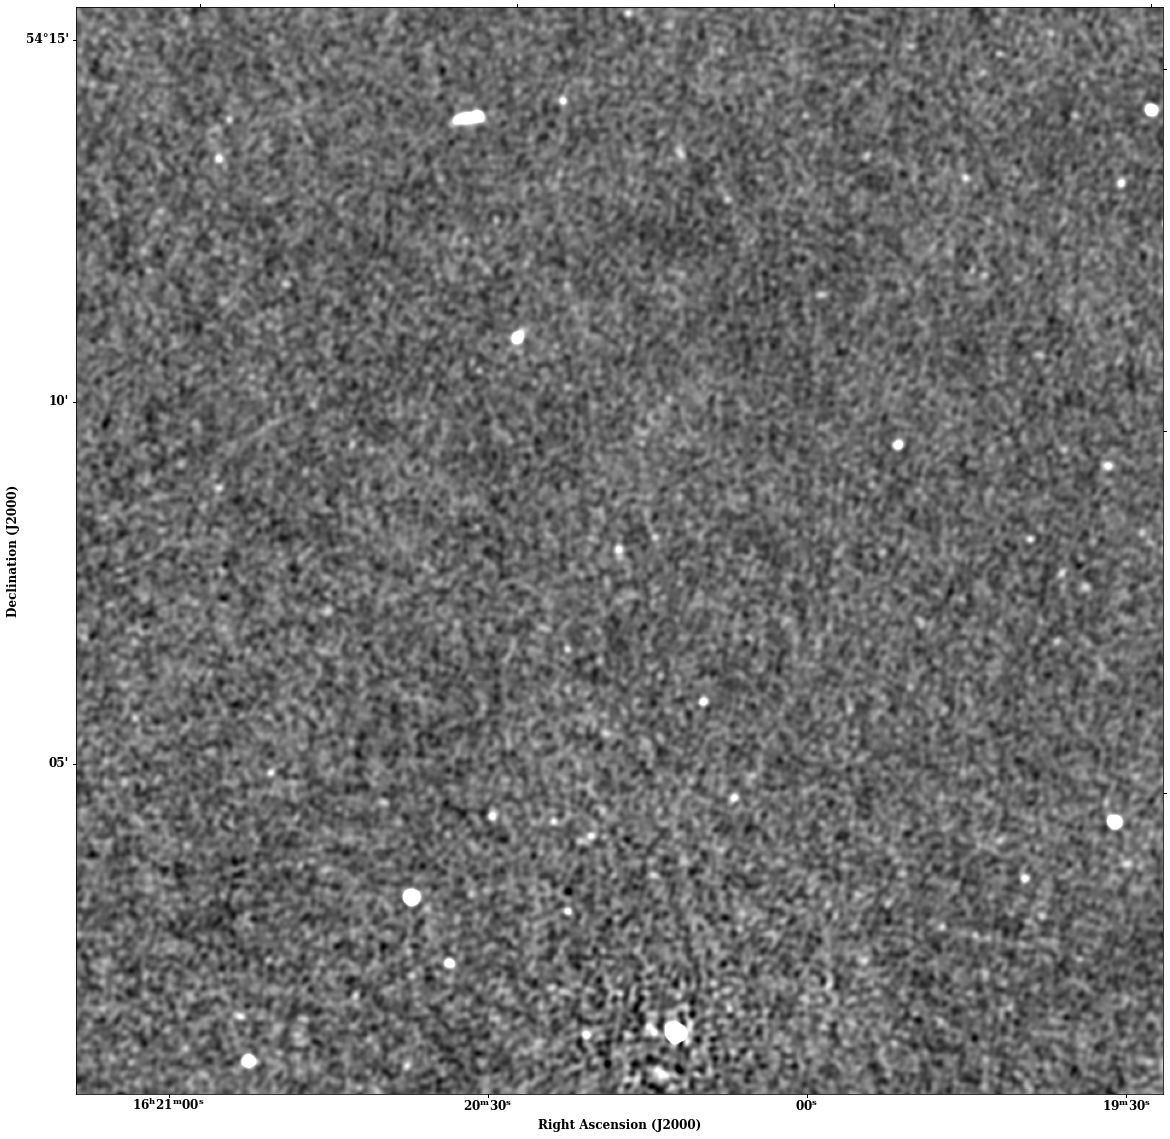

In [10]:
zmin_roi,zmax_roi = functions.zscale(data)
#roi = regi

plt.figure(figsize=(20,20))
ax = plt.gca(projection=wcsradio)
#ax.subplot()
ax.imshow(data,cmap='gray', vmin=zmin_roi, vmax=zmax_roi, origin='lower')

ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
plt.show()

In [19]:
data.shape

(901, 901)

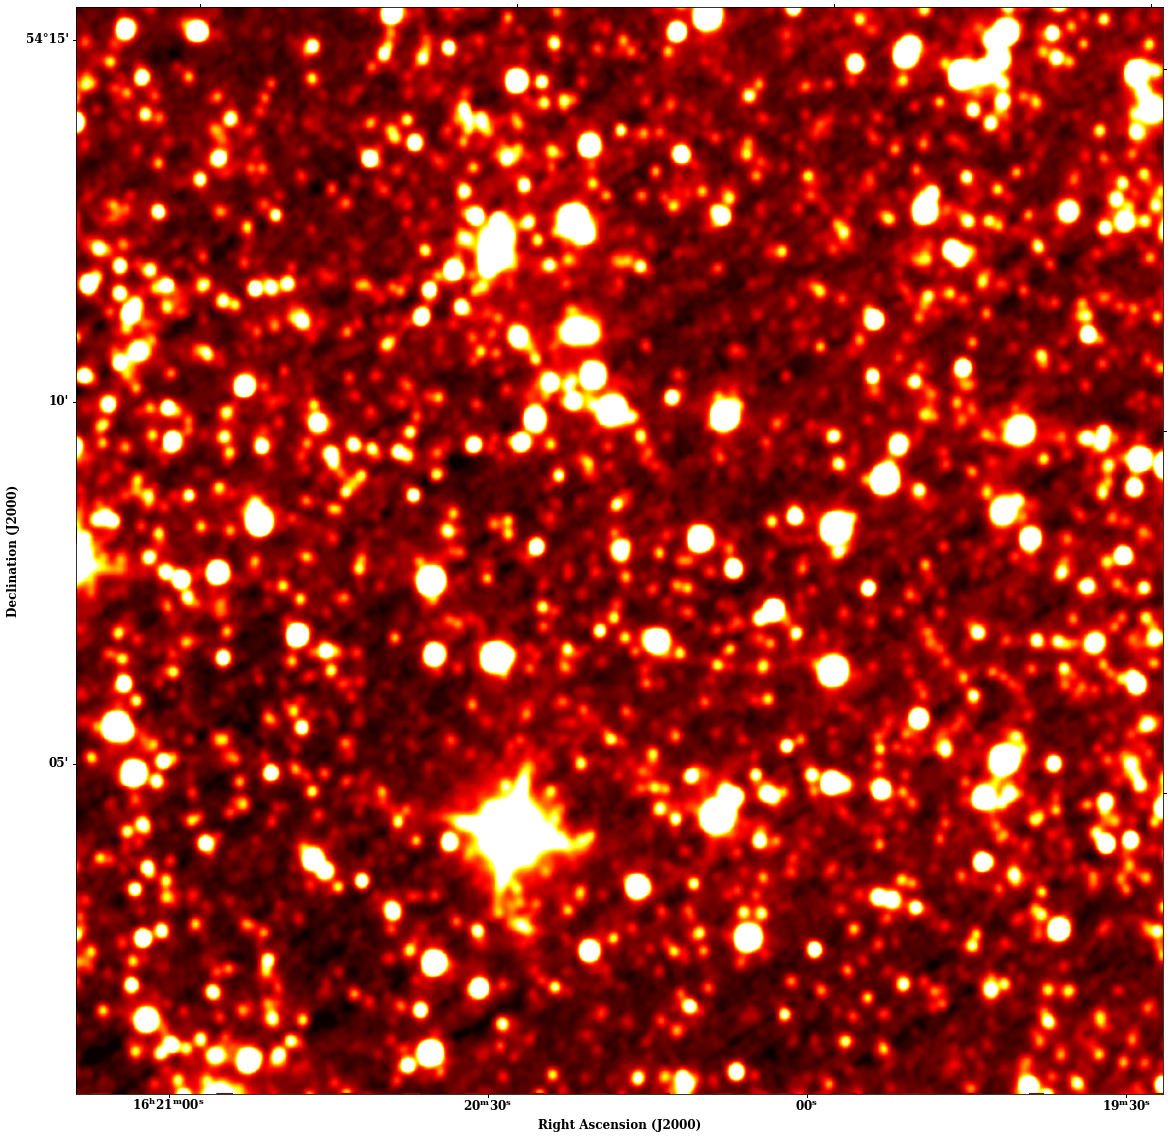

In [18]:
file = pyfits.open(output_fname)
hduwise = file[0]
wcswise = pywcs.WCS(hduwise.header, naxis=2)
#file.close()

zmin_roi_w,zmax_roi_w = functions.zscale(hduwise.data)

plt.figure(figsize=(20,20))
ax = plt.gca(projection=wcswise)
#ax.subplot()
ax.imshow(hduwise.data,cmap='hot', vmin=zmin_roi_w, vmax=zmax_roi_w, origin='lower')

ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
file.close()
plt.show()

The above images reprensent radio and IR images of 15 arcmin covering the same area of the sky.